Library Import

Download Link in https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

In [1]:
import os 
import  shutil
import torch 
import random
import torchvision
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt
from torchsummary import summary
from tqdm.notebook import tqdm
torch.manual_seed(0)

print("Using Pytorch verison", torch.__version__)

Using Pytorch verison 1.8.1


Prepare data

In [2]:
class_names = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['COVID', 'Lung_Opacity', 'Normal','Viral Pneumonia']
test_dir_name ='test'
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, test_dir_name))
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    for c in class_names:
        os.mkdir(os.path.join(root_dir,test_dir_name,c))
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 50)  
        for img in selected_images:
            source_path = os.path.join(root_dir, c, img)
            target_path = os.path.join(root_dir, test_dir_name, c, img)
            shutil.move(source_path, target_path)      
    

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} example ')
            return images
        
        self.images = {}
        self.class_names =['COVID','Lung_Opacity','Normal','Viral Pneumonia']  

        for c in self.class_names:
            self.images[c] = get_images(c)

        self.image_dirs = image_dirs
        self.transform = transform    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
#         print(class_name)
#         print(index, len(self.images[class_name]))

        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
#         print(index, len(self.images[class_name]), image_name, image_path, image)
        
        return self.transform(image), self.class_names.index(class_name)
        

Image Transform

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size =(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229,0.224, 0.225])
])



In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size =(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229,0.224, 0.225])
])



Data Loader 

In [6]:
train_dirs ={
    source_dirs[0] : root_dir+"/"+ source_dirs[0],
    source_dirs[1] : root_dir+"/"+ source_dirs[1],
    source_dirs[2] : root_dir+"/"+ source_dirs[2],
    source_dirs[3] : root_dir+"/"+ source_dirs[3],
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)
print(train_dataset.__len__())


Found 3296 COVID example 
Found 5692 Lung_Opacity example 
Found 9872 Normal example 
Found 1025 Viral Pneumonia example 
19885


In [7]:
test_dirs ={
    'COVID' : 'COVID-19_Radiography_Dataset/test/COVID' ,
    'Lung_Opacity' : 'COVID-19_Radiography_Dataset/test/Lung_Opacity',
    'Normal' : 'COVID-19_Radiography_Dataset/test/Normal',
    'Viral Pneumonia' : 'COVID-19_Radiography_Dataset/test/Viral Pneumonia'
}
# print(test_dirs)

test_dataset = ChestXRayDataset(test_dirs, test_transform)
print(test_dataset.__len__())

Found 50 COVID example 
Found 50 Lung_Opacity example 
Found 50 Normal example 
Found 50 Viral Pneumonia example 
200


In [8]:
batch_size = 6 

dl_train = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size= batch_size,
    shuffle= True
)
dl_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size= batch_size,
    shuffle= False
)

print('Num of training batches', len(dl_train))
print('Num of testing batches', len(dl_test))

Num of training batches 3315
Num of testing batches 34


Data Visualization 

In [9]:
class_names = train_dataset.class_names
# print(class_names)
def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(2,10,i + 1,xticks=[],yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229,0.224, 0.225])
        image = image * std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        color ='green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = color)
    plt.tight_layout()
    plt.show()

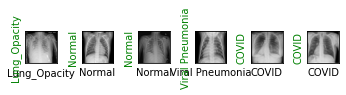

In [10]:

images, labels = next(iter(dl_train))
show_images(images, labels, labels)

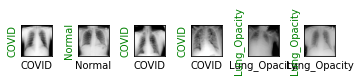

In [11]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

Creating the model

In [12]:
resnet152 = torchvision.models.resnet152(pretrained =True)
print(resnet152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
resnet152.fc = torch.nn.Linear(in_features=2048, out_features=4)

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet152.parameters(), lr=3e-5)

In [15]:
def show_preds():
    resnet152.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet152(images)
    _,preds = torch.max(outputs,1)
    show_images(images, labels, preds)

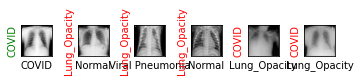

In [16]:
show_preds()

Traininng the model

In [17]:
def train(epochs):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("device: ", device)
    print('Staring training.. ')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss =0

        resnet152.train()
        torch.backends.cudnn.benchmark = True
        for train_step, (images, labels) in tqdm(enumerate(dl_train)):
            optimizer.zero_grad()
            outputs = resnet152(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss+= loss.item()
            if train_step %20 ==0:
                print('Evaluating at step', train_step)
                acc=0.0
                val_loss=0.0
                resnet152.eval()
                for val_step, (images, labels) in tqdm(enumerate(dl_test)):
                    outputs = resnet152(images)
                    loss = loss_fn(outputs, labels)
                    val_loss+= loss.item()
                    _, preds = torch.max(outputs,1)
                    acc+= sum((preds == labels).numpy())
                val_loss /= (val_step +1)
                acc /= len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet152.train()
                
                if acc >0.95:
                    print('Performance condition satisfied ..')
                    return 
        train_loss/= (train_step+1)
        print(f'Training loss: {train_loss:.4f}')
    torch.save(model.state_dict(), "weightsResnet150.pth")    
        
                    
                    

Staring training.. 
Starting epoch 1/2


0it [00:00, ?it/s]

Evaluating at step 0


0it [00:00, ?it/s]

Val loss: 1.4271, Acc: 0.3000


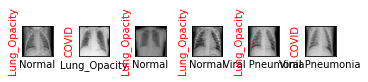

Evaluating at step 20


0it [00:00, ?it/s]

Val loss: 1.0547, Acc: 0.7350


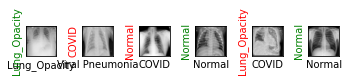

Evaluating at step 40


0it [00:00, ?it/s]

Val loss: 0.8031, Acc: 0.7300


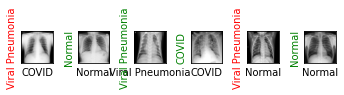

Evaluating at step 60


0it [00:00, ?it/s]

Val loss: 0.6449, Acc: 0.7400


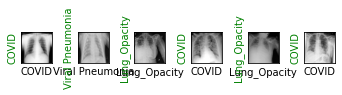

Evaluating at step 80


0it [00:00, ?it/s]

Val loss: 0.6063, Acc: 0.7300


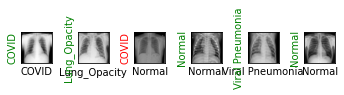

Evaluating at step 100


0it [00:00, ?it/s]

Val loss: 0.4367, Acc: 0.8850


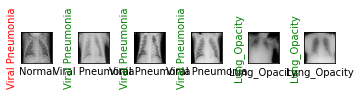

Evaluating at step 120


0it [00:00, ?it/s]

Val loss: 0.4259, Acc: 0.8800


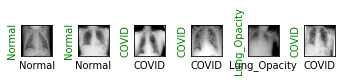

Evaluating at step 140


0it [00:00, ?it/s]

Val loss: 0.3909, Acc: 0.8650


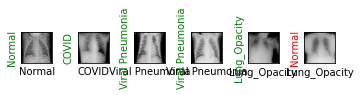

Evaluating at step 160


0it [00:00, ?it/s]

Val loss: 0.2975, Acc: 0.8900


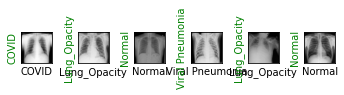

Evaluating at step 180


0it [00:00, ?it/s]

Val loss: 0.3318, Acc: 0.9200


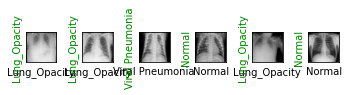

Evaluating at step 200


0it [00:00, ?it/s]

Val loss: 0.2635, Acc: 0.9150


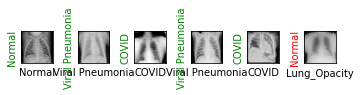

Evaluating at step 220


0it [00:00, ?it/s]

Val loss: 0.2717, Acc: 0.9200


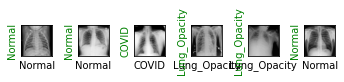

Evaluating at step 240


0it [00:00, ?it/s]

Val loss: 0.2744, Acc: 0.8800


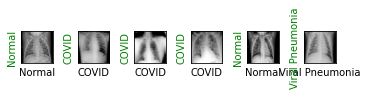

Evaluating at step 260


0it [00:00, ?it/s]

Val loss: 0.2800, Acc: 0.8900


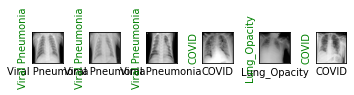

Evaluating at step 280


0it [00:00, ?it/s]

Val loss: 0.2944, Acc: 0.8700


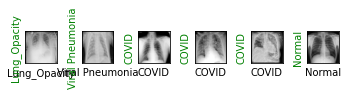

Evaluating at step 300


0it [00:00, ?it/s]

Val loss: 0.2600, Acc: 0.9000


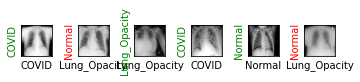

Evaluating at step 320


0it [00:00, ?it/s]

Val loss: 0.3205, Acc: 0.8950


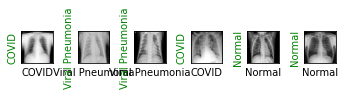

Evaluating at step 340


0it [00:00, ?it/s]

Val loss: 0.2762, Acc: 0.9150


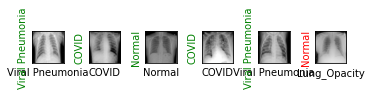

Evaluating at step 360


0it [00:00, ?it/s]

Val loss: 0.2558, Acc: 0.9000


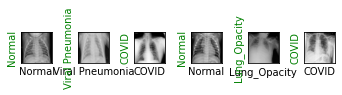

Evaluating at step 380


0it [00:00, ?it/s]

Val loss: 0.3080, Acc: 0.8700


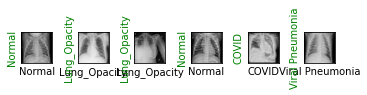

Evaluating at step 400


0it [00:00, ?it/s]

Val loss: 0.4586, Acc: 0.8300


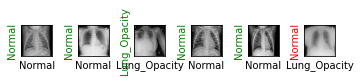

Evaluating at step 420


0it [00:00, ?it/s]

Val loss: 0.2222, Acc: 0.9150


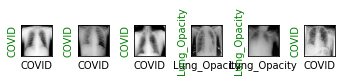

Evaluating at step 440


0it [00:00, ?it/s]

Val loss: 0.2849, Acc: 0.9000


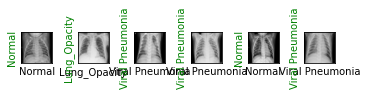

Evaluating at step 460


0it [00:00, ?it/s]

Val loss: 0.2513, Acc: 0.9050


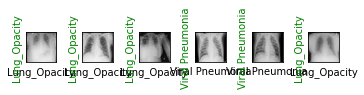

Evaluating at step 480


0it [00:00, ?it/s]

Val loss: 0.3048, Acc: 0.9000


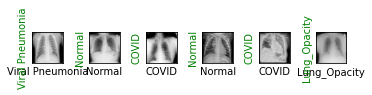

Evaluating at step 500


0it [00:00, ?it/s]

Val loss: 0.2774, Acc: 0.9200


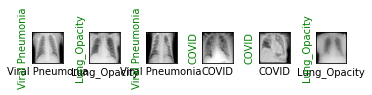

Evaluating at step 520


0it [00:00, ?it/s]

Val loss: 0.2586, Acc: 0.9150


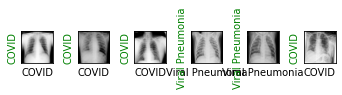

Evaluating at step 540


0it [00:00, ?it/s]

Val loss: 0.2336, Acc: 0.9300


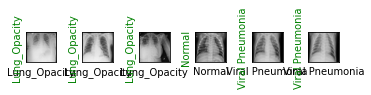

Evaluating at step 560


0it [00:00, ?it/s]

Val loss: 0.1564, Acc: 0.9550


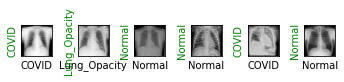

Performance condition satisfied ..


In [18]:
train(epochs=2)

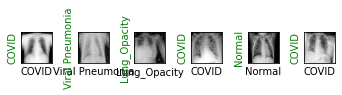

In [20]:
show_preds()